In [58]:
import pandas as pd
import re
pd.options.display.max_rows = 300
pd.options.mode.chained_assignment = None
pd.options.plotting.backend = "matplotlib"

# Determining the Reference Canon
## Processing results of Named Entity Recognition

In the first step we had produced three lists of volumes that serve as a reference corpus to determine canons of philosophy in German, French, and English: [`vols_upload_ger.csv`](<../step_1/output/vols_upload_ger.csv>), [`vols_upload_fren.csv`](<../step_1/output/vols_upload_fren.csv>) and [`vols_upload_eng.csv`](<../step_1/output/vols_upload_eng.csv>). These files were uploaded to https://analytics.hathitrust.org/ as worksets. Hathitrust allows to apply various algorithms to such worksets, among them Named Entity Recognition (NER). The results of this process serve as [input](<input/>) for this notebook: [entities_ger.csv](<input/entities_ger.csv>), [entities_fren.csv](<input/entities_fren.csv>), and [entities_eng.csv](<input/entities_eng.csv>).

Our goal: create three lists of the 100 most frequently named philosophers, one for each subcorpus (German, French, English). Correspondingly, we produce three output files: [`output/top_counts_ger.csv`](<output/top_counts_ger.csv>), [`output/top_counts_fren.csv`](<output/top_counts_fren.csv>), and [`output/top_counts_eng.csv`](<output/top_counts_eng.csv>). 

The structure of this notebook:

* [Corpus analysis](<#Corpus-analysis>)
* [Data cleaning: identifying persons](<#Data-cleaning:-identifying-persons>)
* [Data cleaning: unifying names](<#Data-cleaning:-unifying-names>)
* [Analysis and output](<#Analysis-and-output>)
* [Statistics](<#Statistics>)


## Corpus analysis

A small part of the volumes identified in [step 1](<../step_1>) are not available for the application of the Hathitrust NER algorithm. We therefore look first of all at the overall constitution of the three subcorpora we are working with: books on the history of philosophy in German, French, and English. We first determine the number of books available in each language and then plot each subcorpus in time.

In [59]:
valid_ger = pd.read_csv("input/valid_volumes_ger.csv")
valid_fren = pd.read_csv("input/valid_volumes_fren.csv")
valid_eng = pd.read_csv("input/valid_volumes_eng.csv")
corp_length = {}
corp_length["German"] = len(valid_ger)
corp_length["French"] = len(valid_fren)
corp_length["English"] = len(valid_eng)
corp_length_df = pd.DataFrame.from_dict(corp_length, orient="index")
corp_length_df.columns = ["n books"]
display(corp_length_df)

n books
German      1273
French       319
English     1281

We find almost as many books in German on the history of philosophy in Hathitrust as we find books in English. If we add the fact that a number of titles both in French and English are full or partial translations of German scholarship, this suggests that the canon we investigate will to a large extent be determined by the German historiography of philosophy. Translations have not been identified separately, because we operate under the assumption that a translated text contributes to canon formation in the philosophical culture that utilises the translation. To convey some idea of the temporal distribution of titles we have divided the time span of investigation into periods of 50 years and produce plots of the absolute number of titles per period.

<AxesSubplot:xlabel='period'>

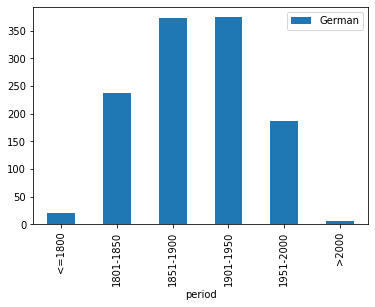

In [60]:
def plot_corpus(df, lang):
    """
    Takes a file with metadata and plots books per period as bar chart.
    """
    corpus_dict = {}
    corpus_dict["<=1800"] = len(df[df["year"] <= 1800])
    corpus_dict["1801-1850"] = len(df[(df["year"] > 1800) &
                                      (df["year"] <= 1850)])
    corpus_dict["1851-1900"] = len(df[(df["year"] > 1850) &
                                      (df["year"] <= 1900)])
    corpus_dict["1901-1950"] = len(df[(df["year"] > 1900) &
                                      (df["year"] <= 1950)])
    corpus_dict["1951-2000"] = len(df[(df["year"] > 1950) &
                                      (df["year"] <= 2000)])
    corpus_dict[">2000"] = len(df[df["year"] > 2000])
    result = pd.DataFrame.from_dict(corpus_dict, orient="index")
    result.columns = [lang]
    result.index = result.index.rename("period")
    plot = result.plot.bar()
    return(plot)
  

plot_corpus_ger = plot_corpus(valid_ger, "German")
display(plot_corpus_ger)

<AxesSubplot:xlabel='period'>

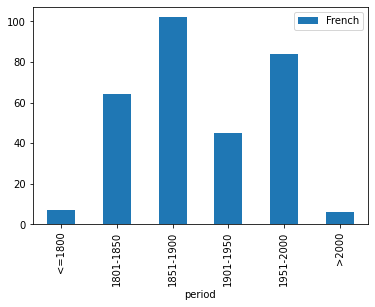

In [61]:
valid_fren = pd.read_csv("input/valid_volumes_fren.csv")
plot_corpus_fren = plot_corpus(valid_fren, "French")
display(plot_corpus_fren)

<AxesSubplot:xlabel='period'>

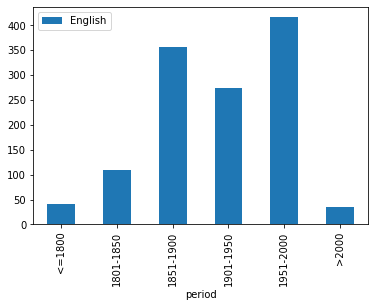

In [62]:
valid_eng = pd.read_csv("input/valid_volumes_eng.csv")
plot_corpus_eng = plot_corpus(valid_eng, "English")
display(plot_corpus_eng)

While we observe both in English and French titles a decrease between 1901 and 1950, after all the period of a huge economic crisis and two world wars, the number of German titles to be found in this period is as high as in between 1851 and 1900. This reinforces the perception that in the framework of this analysis German historiography plays a decisive role.

In [63]:
def read_entities(path):
    """
    Read results of NER.
    """
    entities = pd.read_csv(path, error_bad_lines=False,
                           warn_bad_lines=False)
    entities["entity"] = entities["entity"].str.strip()
    return(entities)

entities_ger = read_entities("input/entities_ger.csv")
entities_fren = read_entities("input/entities_fren.csv")
entities_eng = read_entities("input/entities_eng.csv")

## Data cleaning: identifying persons

For further processing, we first need to produce counts of the entities captured through NER.

In [64]:
def entities_count(df):
    """
    Create df with counts of entities generated in NER.
    """
    ent_count = df["entity"].value_counts().reset_index()
    ent_count.columns = ["Name", "Count"]
    return(ent_count)

ent_count_ger = entities_count(entities_ger)
ent_count_fren = entities_count(entities_fren)
ent_count_eng = entities_count(entities_eng)

The files emitted by the Hathitrust NER process do provide a rough classification of entities as persons, places, organizations or miscellaneous named entities. However, as shown below ([Statistics](<#Statistics>)), the reliability of these classifications is somewhat questionable and would in any case require manual intervention.

We therefore examined the most frequent identified entities and classified them in various blacklists, according to the criteria laid out below. Instead of creating one long blacklist, it seemed to be preferable to group excluded entities according to various criteria.

In [110]:
# blacklists

# Separating categories, because this may be interesting for later analyses.

places_ger = ["Paris", "Berlin", "Berl", "Leipzig", "London", "Erde",
          "Bonn", "München", "Milano", "Lips", "Madrid", "Breslau",
          "Roma", "Mnchn", "Freiburg", "Stuttgart", "Tübingen",
          "Oxford", "Zürich", "Athen", "Jena", "Rom", "Wien", "Mchn",
          "Köln", "Rhein", "Heidelberg", "Göttingen", "Münster", "Münch",
          "Bern", "Torino", "Hamburg", "Basel", "Königsberg", "Prag",
          "Florenz", "Amsterdam", "Napoli", "Mond", "Cambridge",
          "Bologna", "New York", "Mainz", "Erlangen", "Heidelb", "Marburg",
          "Neapel", "Gotha", "Buenos Aires", "Москва", "Halle", "Venedig",
          "Kiel", "N. Y.", "Barcelona", "Padua", "Hannover", "Mailand",
          "Bari", "Würzburg", "Darmstadt", "Louvain", "Frankfurt", "Alexandria",
          "Lyon", "Genf", "Dresden", "Budapest", "Chicago", "Canterbury",
          "Frankf", "Samos", "Weimar", "Nürnberg", "Preußen", "Jerusalem"]
places_fren = ["Paris", "Rome", "Athènes", "Berlin", "Alexandrie", "Oxford",
         "Londres", "Leipzig", "Louvain", "Chartres", "Venise", "Florence",
         "Madrid", "Lyon", "Cologne", "Constantinople", "Naples"]
places_eng = ["Paris", "Athens", "Rome", "London", "Berlin", "New York",
              "Oxford", "Alexandria", "Sparta", "Cambridge", "Leipsic",
              "Leipzig", "Sicily", "Halle", "Jena", "Vienna", "Venice",
              "Olymp", "Thebes", "Florence", "Edinburgh", "Syracuse",
              "Naples", "Munich", "Amsterdam", "Jerusalem", "Corinth",
              "Geneva", "Bonn", "Heidelberg"]

# Blacklisting periods

periods_ger = ["Renaissance", "Mittelalter"]
periods_fren = ["Renaissance"]
periods_eng = []

# Blacklisting schools 

schools_ger = ["Marxismus", "Neuplatonismus"]
schools_fren = ["Stoïciens", "christianisme", "idéalisme", "platonicienne",
                "cartésienne", "Sorbonne", "Pythagoriciens", "Christianisme",
                "Islam"]
schools_eng = ["Aristotelian", "Platonic", "Pythagoreans", "Christians",
          "Pythagorean", "Socratic", "Kantian", "Stoics", "Cartesian",
          "Christianity", "Hegelian", "Sophists", "Eleatic", "Catholic",
          "Buddhist", "Buddhism", "Stoic", "Judaism", "Epicureans",
          "Jesuits", "Epicurean", "Cynics", "Islam", "Muslim", "Ionian",
          "Platonism", "Neo-Platonic"]


# Blacklisting peoples

peoples_ger = ["Griechen", "Römer", "Pariser", "Berliner", "Engländer",
          "Athener", "Franzosen"]
peoples_fren = ["Grecs"]
peoples_eng = ["Germans", "Arabs"]


# Blacklisting countries

countries_ger = ["Frankreich", "England", "Deutschland", "Italien",
                 "Griechenland", "Europa", "Spanien", "Rußland", "Indien",
                 "Alexandrien", "Holland", "Deutſchland", "China",
                 "Ägypten", "Schweiz", "Frankreichs", "Polen", "Europas",
                "Amerika"]
countries_fren = ["France", "Angleterre", "Allemagne", "Italie",
             "Grèce", "Europe", "Orient", "Occident", "Espagne",
             "Inde", "Afrique", "Hollande", "Asie", "Egypte", 
             "Byzance"]
countries_eng = ["Greece", "France", "England", "Europe", "Germany", "Italy",
            "Egypt", "Earth", "India", "Asia", "Spain", "China", "America",
            "Persia", "Africa", "Russia", "Holland", "Sun", "Syria", "Israel",
            "United States", "Scotland", "Ireland"]

# Blacklisting junk

junk_ger = ["$", "Chr", "her", "Gesch", "Fr", "Phil", "his", "Christi", "Joh", "Mus",
        "Dinges", "Journ", "Wilh", "K.s", "Herm", "Hugo", "he", "D.", "Dieſe", "Nic",
        "Sofie", "Wilhelm", "engl.", "Jo", "L.", "Stob", "Dieſes", "Ludw", "Rich",
       "Giorn", "franz.", "Gust", "Stud", "Chr.", "Sch", "Jac", "L.s", "Thom", "He",
       "Tim", "Cap", "Hc", "Ibid", "Alſo", "Noth", "Dieſer", "Tom", "Ebenda"]
junk_fren = ["1", "Ainsi", "III", "Ibid", "VII", "L.", "VIII", "J.", "Diog", "Telle",
             "P.", "V.", "ibid", "XIII", "3", "VI", "Hist", "Ch", "C.", "lib", "Arist",
             "V", "Eth", "XII", "—", "éd", "Plut", "Cic", ")", "Th", "A.", "Sur", 
             "Cette", "G.", "suiv", "Quelle", "Phil", "quod", "hoc", "XVIII",
             "*","-", "B.", "Die", "his", "Car", "XI", "A.)", "Sext", "11", "1,", "P. G.", 
             "XVII", "G.)", "trad", "Moi"]
junk_eng = ["his", "he", "him", "He", "His", "her", "she", "Him", "spring", "she",
        "She", "1869", "1868", "Gesch", "1866", "1867", "1865", "XII", "1870",
        "Diog", "Her", "Jo"]

# Blacklisting miscellaneous

misc_ger = ["Bibel", "Brahman", "Princip", "Zeus", "Phaidon", "Menon"]
misc_fren = ["doctrine", "logique", "abord", "univers", "théologie",
       "métaphysique", "théorie", "Philosophie", "État", "homme",
       "Etat", "gouvernement", "unité", "Église", "chrétienne",
       "Eglise", "intelligence", "pensée", "Université", "rationnelle",
       "Métaphysique", "Providence", "Logique", "infini", "Théorie",
       "Divinité", "intellect", "Timée", "Bien", "entendement", "place",
       "République", "Académie", "Essai", "Enfin", "Critique", "priori",
       "Nature", "Verbe", "école", "absolu", "Histoire", "Être",
       "Physique", "Aussi", "espace", "Deus", "Toutefois", "astronomie",
       "individuelle", "intuition", "Geschichte", "spirituel", "matière",
       "Idée", "immortalité de l'âme", "ordre", "Lettre", "histoire",
       "Dei", "Esprit", "trinité", "imagination", "géométrie", "corporel",
       "Discours", "Traité", "Deo", "Etre", "Bibliographie", "Créateur",
       "Bible", "immuable", "École", "intellectuel", "multiple",
       "Sentences", "croyance", "Voy", "Summa", "Phédon", "Morale",
       "Ecole", "causalité", "médecine", "Raison", "langage", "Trinité",
       "Éthique", "Dieux", "évidence", "Encyclopédie", "théologien",
       "Intelligence", "scolastique", "rationnel", "génération", "genre humain",
       "Théologie", "idée", "général", "Méditations", "théodicée", "Deum", 
        "Écriture", "induction", "dialectique", "grammaire", "intelligible",
       "immortalité", "Etudes", "lumière", "luimême", "Absolu", "historien",
        "histoire de la philosophie"]
misc_eng = ["State", "eighteenth century", "Western", "seventeenth century", "Academy",
       "Vedas", "Hebrew", "Essay"]
         
# Unclear
unclear_ger = ["Hermes", "Werth", "Theil", "Johannes", "Adam", "Müller",
               "Thun", "Wiener", "Schmidt", "Sonne", "Clemens", "Richard",
               "Christo", "Uebel", "Ott", "Weber", "Schneider", "Wagner",
               "Petrus", "Gilbert", "David", "Franz", "Alexander", "Prometheus",
               "Muth", "Karl"]
unclear_fren = ["Dieu", "Guillaume", "Grand", "Pierre", "Jean", "Père",
          "Nicolas", "Gilbert", "Grégoire", "Henri", "Denys", "Adam",
          "David", "Robert", "Clément", "Régis", "Gilles", "Alexandre",
          "Lois"]
unclear_eng = ["Christian", "Philip", "Brahman", "Jews", "John", "Church",
           "William", "James", "Phil", "Peter", "Paul", "East", "Adam",
          "Smith", "Henry", "Providence", "Clement", "Nicholas", "Gregory",
          "Alexander", "Charles", "Law", "Bernard"]

# Blacklisting adjectives (nationalities, schools etc.)
          
natio_ger = [r"deutsch*", r"griechisch*", r"französisch*", r"römisch*", r"arabisch*",
        r"englisch*", r"Deutsch*", r"lateinisch*", r"russisch*", r"marxistisch*", 
         "indisch*", r"Aristotelisch*", r"europäisch*", r"christlich*", r"italienisch*",
        r"Hegelsch*", r"Kantisch*", r"franzöſiſch*"]
natio_fren = ["grecq", "Arabes", "Romains", "grecque"]
natio_eng = ["Greeks", "Athenians", "Greek", "Persians","Greek", "German", 
         "English", "French", "Roman", "Jewish", "Athenian",
         "Grecian", "Persian", "Indian", "European", "Chinese", "Italian",
         "Arabic", "American", "British", "Spartan", "Egyptian", "Russian",
         "Macedonian", "Egyptians", "Thebans", "Japanese", "Arabian",
        "Alexandrian", "Spanish", "Hellenic"]

In [111]:
blocklist_ger = places_ger + periods_ger + schools_ger + peoples_ger + \
                countries_ger + junk_ger + misc_ger + unclear_ger

blocklist_fren = places_fren + periods_fren + schools_fren + peoples_fren + \
                countries_fren + junk_fren + misc_fren + unclear_fren + natio_fren
blocklist_eng = places_eng + periods_eng + schools_eng + peoples_eng + \
                countries_eng + junk_eng + misc_eng + unclear_eng + natio_eng

def entities_clean(df, blocklist):
    """
    Clean entity count
    """
    df["block_bool"] = df["Name"].isin(blocklist)
    result_df = df[df["block_bool"] == False]
    return(result_df)

phils_raw_ger = entities_clean(ent_count_ger, blocklist_ger)
phils_raw_fren = entities_clean(ent_count_fren, blocklist_fren)
phils_raw_eng = entities_clean(ent_count_eng, blocklist_eng)

# In order to deal with the flexion of adjectives in German "natio" is treated separately in that language.

for nat in natio_ger:
    phils_raw_ger["entity_bool"] = phils_raw_ger["Name"].str.match(nat)
    phils_raw_ger = phils_raw_ger[phils_raw_ger["entity_bool"] == False]

## Data cleaning: unifying names

Names identifying philosophers are not used in a uniform manner within a subcorpus (German, French, or English). The German case poses special challenges: the Hathitrust NER output for German records nominatives (Kant) and genitives (Kants) as different names. This creates several subtasks: 

* we must first see which of the most frequently recorded names of philosophers are genitives and create an additional column of lemmatised names (names in the nominative).

* we must then see for which of the most frequently recorded names of philosophers a genitive is contained in the NER result file as a whole.

These two subtasks are specific for German, the third is required for all subcorpora:

* we add a list of manual corrections (correcting frequent OCR errors, creating preferred names for individuals with different name forms, e. g. Augustine).

In [112]:
# We now generate "replacement tuples" for unifying names of philosophers.
# First German: here we face the problem that genitive and nominative are different. 
# And genitives differ depending on the ending of the name. 

ger_top_raw = phils_raw_ger.head(131)
ger_top_raw_list = ger_top_raw["Name"].to_list()

genit_1 = [x + "s" for x in ger_top_raw_list if x[-1] != "s" and x[-1] !="x" and x[-1] !="z"]
genit_2 = [x + "ens" for x in ger_top_raw_list if x[-1] == "z" or x[-1] == "x"]

# First case: the genitive is already in our top list.

genit_in_list_1 = [x for x in genit_1 if x in ger_top_raw_list]
genit_in_list_2 = [x for x in genit_2 if x in ger_top_raw_list]
genit_in_list = genit_in_list_1 + genit_in_list_2

# We reconstitute the lemma in nominative and create a list of "replacement tuples"
# If we know that the reconstituted lemma deviates from the name we use in the end, we correct manually.

genit_lemmat = [x.strip(x[-1]) for x in genit_in_list]
genitives = list(zip(genit_in_list, genit_lemmat))
genitives[3] = ("Platos", "Platon")
genitives[12] = ("Augustins", "Augustinus")

# We add manual replacement tuples.

manual_lemmat = [("Plato", "Platon"), ("Jesu", "Christus"), ("Jesus", "Christus"),
                ("Chriſtus", "Christus"), ("W. I. Lenin", "Lenin"), 
                ("Augustin", "Augustinus"), ("Ariſtoteles", "Aristoteles"), 
                ("Thomas von Aquino", "Thomas"), ("Thomas von Aquin", "Thomas"), 
                ("Carteſius", "Descartes"), ("Cartesius", "Descartes"),
                ("Leibnitz", "Leibniz"), ("Giordano Bruno", "Bruno"),
                ("Scotus", "Duns Scotus"), ("Albertus Magnus", "Albert"),
                ("Baco", "Bacon"), ("Piaton", "Platon"), ("Wolf", "Wolff"),
                ("Zeno", "Zenon"), ("Karl Marx", "Marx"), ("Chriſti", "Christus"),
                ("Fichtes", "Fichte"), ("Herders", "Herder")]
lemmat_replace = genitives + manual_lemmat
lemmat_replace

#Hack, because there is an additional Jesus, and I lack the time to find out where he's coming from.

lemmat_replace = [x for x in lemmat_replace if x != ("Jesus", "Jesu")]

In [113]:
# In order to have somewhat correct counts, we should for those authors 
# without top results for genitives find their genitive form in the complete NER result.

more_genit_1 = [x for x in genit_1 if x not in ger_top_raw_list]
more_genit_2 = [x for x in genit_2 if x not in ger_top_raw_list]

more_genit_1_lemma = [x.strip(x[-1]) for x in more_genit_1]
more_genit_2_lemma = [x.strip("ens") for x in more_genit_2] 
more_genit_list = more_genit_1 + more_genit_2
more_genit_lemma = more_genit_1_lemma + more_genit_2_lemma
more_genitives = list(zip(more_genit_list, more_genit_lemma))

In [114]:
# We remove tupels with errors from the list and add the correct ones.

false_tuples = [("Piatons", "Piaton"), ("Thomas von Aquins", "Thomas von Aquin"), 
              ("Thomas von Aquinos", "Thomas von Aquino"), ("Wolfs", "Wolf"),
              ("Bacos", "Baco"), ("Leibnitzens", "Leibnitz"), 
              ("W. I. Lenins", "W. I. Lenin"), ("Zenos", "Zeno"),
             ('Chriſtis', 'Chriſti'), ('Karl Marxens', 'Karl Marx')]
corr_tuples = [("Piatons", "Platon"), ("Thomas von Aquins", "Thomas"),
             ("Thomas von Aquinos", "Thomas"), ("Wolfs", "Wolff"),("Bacos", "Bacon"),
             ("Leibnitzens", "Leibniz"), ("W. I. Lenins", "Lenin"),
             ("Zenos", "Zenon"), ('Chriſtis', 'Christus'), ('Karl Marxens', 'Marx'),]
mg_1 = [x for x in more_genitives if x not in false_tuples]
more_genitives_corr = mg_1 + corr_tuples

# We need a list of the original genitives, including false ones, 
# to find the in the original NER result.

mg_corr_list = [x[0] for x in more_genitives_corr]

In [115]:
## Are there genitives in the list for which we have no nominatives?

# List of philosopher names ending in "s"

end_with_s = [x for x in ger_top_raw_list if x[-1] == "s"]

ews_no_s = [x.rstrip("s") for x in end_with_s]
ews_not_in_list = [x for x in ews_no_s if x not in ger_top_raw_list]

In [116]:
def name_in_ent(entities_df, name):
    """
    Test whether a given name is in the NER result.
    """
    name_set = set(entities_df["entity"].to_list())
    if name in name_set:
        name_df = entities_df[entities_df["entity"] == name]
    else:
        name_df = pd.DataFrame()
    return(name_df)

nominatives_pd = pd.DataFrame()

for name in ews_not_in_list:
    nomin_df = name_in_ent(entities_ger, name)
    if len(nomin_df) == 0:
        print(f"{name} not found in NER result.")
    else:
        if name == "Fichte" or name == "Herder" or name == "Mose":
            nomin_count = nomin_df["entity"].value_counts().reset_index()
            nomin_count.columns = ["Name", "Count"]
            if name != "Mose":
                nomin_count["Lemma"] = name
            else:
                nomin_count["Lemma"] = "Moses"
            nominatives_pd = pd.concat([nominatives_pd, nomin_count])
        else:
            print(f"{name} found in NER results: {len(nomin_df)} hits.")
nominatives_pd

Aristotele found in NER results: 126 hits.
Sokrate not found in NER result.
Descarte not found in NER result.
Thoma found in NER results: 115 hits.
Hobbe found in NER results: 2 hits.
Engel found in NER results: 449 hits.
Pythagora found in NER results: 15 hits.
Anaxagora found in NER results: 4 hits.
Christu found in NER results: 5 hits.
Parmenide found in NER results: 7 hits.
Augustinu found in NER results: 1 hits.
Thale found in NER results: 54 hits.
Paulu found in NER results: 6 hits.
Gorgia found in NER results: 328 hits.
Duns Scotu found in NER results: 2 hits.
Maimonide found in NER results: 7 hits.
Xenophane found in NER results: 20 hits.
Chriſtu not found in NER result.
Ariſtotele found in NER results: 3 hits.
Cartesiu found in NER results: 2 hits.
Simpliciu found in NER results: 8 hits.
Thomasiu found in NER results: 9 hits.
Grotiu found in NER results: 2 hits.
Carteſiu found in NER results: 2 hits.
Steffen found in NER results: 59 hits.
Averroe found in NER results: 7 hits.


Name  Count   Lemma
0  Fichte   1725  Fichte
0    Mose    655   Moses
0  Herder    803  Herder

The result of this test shows that we should not put too much trust into the OCR quality of the underlying raw texts. However, since we are now only interested in relative rankings of philosophers it is not necessary to correct obvious OCR mistakes in this stage. This means that we integrate only Mose, Fichte and Herder into the final counts.

In [117]:
# We create a dataframe with additional genitives from the full NER result.

phils_raw_ger["genitive"] = phils_raw_ger["Name"].isin(mg_corr_list)
phils_more_gen = phils_raw_ger[phils_raw_ger["genitive"] == True]
phils_more_gen = phils_more_gen[["Name", "Count", "entity_bool"]]

# We create a dataframe from corrected tuples.

mg_corr_df = pd.DataFrame(more_genitives_corr)
mg_corr_df.columns=["Name", "Lemma"]
phils_more_gen_lem = phils_more_gen.merge(mg_corr_df, how="left", on="Name")

In [118]:
# After having dealt with genitives, we take the first round of corrections 
# and merge it with the original top list of our philosopher count. For names
# in the nominative we use the "Name" value for the "Lemma" column.

orig_corr_df = pd.DataFrame(lemmat_replace)
orig_corr_df.columns=["Name", "Lemma"]

ger_top_clean = ger_top_raw.merge(orig_corr_df, how="left", on="Name")

In [119]:
ger_top_clean["Lemma"] = ger_top_clean["Lemma"].fillna(
    value = ger_top_clean["Name"])
ger_top_all = pd.concat([ger_top_clean, phils_more_gen_lem, nominatives_pd]).reset_index()

In [125]:
# French

manual_lemmat = [("Aquin", "Thomas"), ("Boëce", "Boèce"), ("Jésus", "Christ"),
                ("Jésus-Christ", "Christ"), ("Leibnitz", "Leibniz"), 
                ("S. Thomas", "Thomas"), ("Saint Thomas", "Thomas"), 
                ("Scot", "Duns Scot"), ("Spinosa", "Spinoza"), 
                ("saint Augustin", "Augustin"), ("saint Thomas", "Thomas"),
                ("Leibnitz", "Leibniz"), ("Duns-Scot", "Duns Scot"), 
                ("Saint Augustin", "Augustin"), ("Ockam", "Occam"),
                ("Stuart Mill", "Mill"), ("Wolf", "Wolff"), ("Maine", "Biran"),
                ("Jean Scot", "Duns Scot"), ("Épicure", "Epicure")]

fren_top_raw = phils_raw_fren.head(120)
fren_corr = pd.DataFrame(manual_lemmat)
fren_corr.columns=["Name", "Lemma"]
fren_lemmas = fren_top_raw.merge(fren_corr, how="left", on="Name")
fren_lemmas["Lemma"] = fren_lemmas["Lemma"].fillna(value=fren_lemmas["Name"])
fren_lemmas

Name  Count  block_bool           Lemma
0          Aristote  40722       False        Aristote
1            Platon  32641       False          Platon
2         Descartes  26849       False       Descartes
3              Kant  17006       False            Kant
4           Socrate  11973       False         Socrate
5       Malebranche  11470       False     Malebranche
6             Locke  10828       False           Locke
7           Leibniz  10502       False         Leibniz
8             Hegel   8872       False           Hegel
9            Thomas   8580       False          Thomas
10          Spinoza   8313       False         Spinoza
11            Bacon   6293       False           Bacon
12         Augustin   6108       False        Augustin
13           Fichte   5378       False          Fichte
14           Plotin   5063       False          Plotin
15        Schelling   4773       False       Schelling
16           Albert   4743       False          Albert
17           Hobbes   4302       False          Hobbes
18         Leibnitz   4167       False         Leibniz
19         Leibnitz   4167       False         Leibniz
20             Hume   3891       False            Hume
21          Cicéron   3677       False         Cicéron
22         Rousseau   3597       False        Rousseau
23          Arnauld   3549       False         Arnauld
24          Abélard   3528       False         Abélard
25        Condillac   3515       False       Condillac
26           Cousin   3217       False          Cousin
27           Pascal   3082       False          Pascal
28        Démocrite   2807       False       Démocrite
29        Anaxagore   2802       False       Anaxagore
30           Newton   2747       False          Newton
31        Parménide   2721       False       Parménide
32         Gassendi   2713       False        Gassendi
33          Bossuet   2659       False         Bossuet
34          Spinosa   2642       False         Spinoza
35           Christ   2579       False          Christ
36            Biran   2513       False           Biran
37        Héraclite   2485       False       Héraclite
38         Berkeley   2473       False        Berkeley
39          Épicure   2463       False         Epicure
40            Bayle   2444       False           Bayle
41         Porphyre   2428       False        Porphyre
42        Pythagore   2400       False       Pythagore
43         Voltaire   2365       False        Voltaire
44      Montesquieu   2310       False     Montesquieu
45           Philon   2283       False          Philon
46            Zénon   2008       False           Zénon
47          Diogène   1989       False         Diogène
48         Averroès   1961       False        Averroès
49         Avicenne   1920       False        Avicenne
50            Bruno   1893       False           Bruno
51          Anselme   1881       False         Anselme
52     Schopenhauer   1871       False    Schopenhauer
53        S. Thomas   1867       False          Thomas
54           Jacobi   1867       False          Jacobi
55          Galilée   1853       False         Galilée
56        Montaigne   1815       False       Montaigne
57            Aquin   1812       False          Thomas
58          Origène   1803       False         Origène
59          Epicure   1794       False         Epicure
60            Boèce   1733       False           Boèce
61             Scot   1701       False       Duns Scot
62        Duns-Scot   1698       False       Duns Scot
63          Proclus   1666       False         Proclus
64            Comte   1622       False           Comte
65       Protagoras   1555       False      Protagoras
66          Fénelon   1508       False         Fénelon
67          Diderot   1507       False         Diderot
68        Empédocle   1469       False       Empédocle
69          Bernard   1467       False         Bernard
70          Sénèque   1440       False         Sénèque
71             Reid   1426       False            Reid


In [126]:
# English

manual_lemmat = [("Aquinas", "Thomas"), ("Jesus", "Christ"), 
                 ("Leibnitz", "Leibniz"), ("St. Thomas", "Thomas"),
                 ("Occam", "Ockham"), ("St. Augustine", "Augustine"), 
                 ("Thomas Aquinas", "Thomas"), ("Leibnitz", "Leibniz")]


eng_top_raw = phils_raw_eng.head(120)
eng_corr = pd.DataFrame(manual_lemmat)
eng_corr.columns=["Name", "Lemma"]
eng_lemmas = eng_top_raw.merge(eng_corr, how="left", on="Name")
eng_lemmas["Lemma"] = eng_lemmas["Lemma"].fillna(value=eng_lemmas["Name"])
eng_lemmas

Name   Count  block_bool           Lemma
0         Aristotle  161659       False       Aristotle
1             Plato  158167       False           Plato
2              Kant  102360       False            Kant
3             Hegel   74900       False           Hegel
4          Socrates   70239       False        Socrates
5             Locke   60541       False           Locke
6           Spinoza   45810       False         Spinoza
7         Descartes   40392       False       Descartes
8              Hume   39118       False            Hume
9         Schelling   28599       False       Schelling
10          Leibniz   26562       False         Leibniz
11           Christ   24126       False          Christ
12         Berkeley   22951       False        Berkeley
13            Bacon   21148       False           Bacon
14       Democritus   19828       False      Democritus
15         Leibnitz   19658       False         Leibniz
16         Leibnitz   19658       False         Leibniz
17           Thomas   17961       False          Thomas
18           Hobbes   17790       False          Hobbes
19         Rousseau   17382       False        Rousseau
20           Newton   17192       False          Newton
21       Anaxagoras   16067       False      Anaxagoras
22        Augustine   15382       False       Augustine
23     Schopenhauer   15176       False    Schopenhauer
24           Cicero   15157       False          Cicero
25       Pythagoras   14891       False      Pythagoras
26       Heraclitus   14073       False      Heraclitus
27         Epicurus   13938       False        Epicurus
28       Empedocles   12136       False      Empedocles
29       Parmenides   11799       False      Parmenides
30           Fichte   11152       False          Fichte
31         Voltaire   10923       False        Voltaire
32         Xenophon   10406       False        Xenophon
33        Nietzsche   10326       False       Nietzsche
34         Plutarch   10140       False        Plutarch
35             Marx    9881       False            Marx
36          Abelard    9786       False         Abelard
37             Reid    9245       False            Reid
38            Bruno    8948       False           Bruno
39       Maimonides    8784       False      Maimonides
40         Diogenes    8464       False        Diogenes
41          Russell    8054       False         Russell
42           Ockham    7973       False          Ockham
43            Philo    7972       False           Philo
44            Wolff    7936       False           Wolff
45             Zeno    7799       False            Zeno
46          Herbart    7773       False         Herbart
47   Schleiermacher    7711       False  Schleiermacher
48      Malebranche    7703       False     Malebranche
49          Aquinas    7632       False          Thomas
50           Thales    7547       False          Thales
51          Spencer    7461       False         Spencer
52            Jesus    7097       False          Christ
53          Bentham    7033       False         Bentham
54      Anaximander    6931       False     Anaximander
55   Thomas Aquinas    6886       False          Thomas
56           Jacobi    6714       False          Jacobi
57           Anselm    6653       False          Anselm
58             Mill    6633       False            Mill
59           Zeller    6531       False          Zeller
60           Buddha    6522       False          Buddha
61           Darwin    6413       False          Darwin
62           Origen    6319       False          Origen
63         Avicenna    6166       False        Avicenna
64      Montesquieu    5988       False     Montesquieu
65           Seneca    5891       False          Seneca
66            Dewey    5881       False           Dewey
67       St. Thomas    5875       False          Thomas
68     Wittgenstein    5820       False    Wittgenstein
69    St. Augustine    5721       False       Augustine
70          Gorgias    5623       False

## Analysis and output

Value counts and output. In order to be useful, we still need to map the lists of names we have obtained to unique identifiers (Wikidata IDs). See for this the second notebook in this step, [`reconcile_philosophers,ipynb`](../step_2/reconcile_philosophers,ipynb).

## Statistics

The separation of blacklisted terms for blocking entity names that do not refer to persons, but other named entities allows us to provide some preliminary evaluation of the reliability of the Hathitrust NER algorithm in classifying named entities. For this we have matched the respective list of entities with the complete output of the NER algorithm. This means that for example 2.78% of all mentions of names of German philosophers in our German subcorpus are classified not as the mention of a person, but as the mention of a place.

The French version of the algorithm identifies only 61.34% of all mentions of a philosopher name as a reference to a person, 37.23% of all mentions are classified as references to a place (*lieu*). In English, 0.04% of all mentions of a philosopher are classified in this way, too.

These numbers suggest that the manual cleaning of the NER work product was in this case advisable. 

In [122]:
def count_categ(entities, input_list):
    """
    Count categories in NER output.
    """
    input_ser = pd.Series(input_list)
    input_ser.name = "Name"
    output_pd  = entities.merge(input_ser, left_on = "entity", right_on = "Name", how="inner")
    output_count = output_pd["type"].value_counts().reset_index()
    output_count.columns = ["type", "count"]
    output_count["%"] = round((output_count["count"]/output_count["count"].sum())*100,2)
    return(output_count)
    
eval_pers_ger = count_categ(entities_ger, ger_top_raw["Name"].to_list())
eval_pers_ger

type    count      %
0        PERSON  1075430  96.36
1      LOCATION    31035   2.78
2          MISC     5292   0.47
3  ORGANIZATION     4303   0.39

In [78]:
eval_pers_fren = count_categ(entities_fren, fren_top_raw["Name"].to_list())
eval_pers_fren

type   count      %
0  PERS  246158  61.34
1  LIEU  149424  37.23
2   ORG    5737   1.43

In [79]:
eval_pers_eng = count_categ(entities_eng, fren_top_raw["Name"].to_list())
eval_pers_eng

type   count      %
0        PERSON  667836  84.56
1      LOCATION   71413   9.04
2  ORGANIZATION   49655   6.29
3          MISC     900   0.11

In [131]:
# Summarizing counts

def top_counts(input_df, output_path):
    """
    Create top 100 list from intermediate results
    """
    top_counts = input_df.groupby("Lemma")["Count"].sum().reset_index()
    #display(top_counts)
    top_counts.columns = ["Philosopher", "Count"]
    top_counts_100 = top_counts.sort_values(by="Count", ascending=False).head(100)
    top_counts_100.to_csv(output_path)
    print(f"Results saved to {output_path}.")
    return(top_counts_100)

top_counts_ger = top_counts(ger_top_all, "output/top_counts_ger.csv")
top_counts_fren = top_counts(fren_lemmas, "output/top_counts_fren.csv")
top_counts_eng = top_counts(eng_lemmas, "output/top_counts_eng.csv")

Results saved to output/top_counts_ger.csv.
Results saved to output/top_counts_fren.csv.
Results saved to output/top_counts_eng.csv.


In case anyone is curious we have also added the classification ratios for two other types of entities (place names and countries).

In [130]:
eval_place_ger = count_categ(entities_ger, places_ger)
eval_place_ger

type   count      %
0      LOCATION  447898  90.69
1        PERSON   41716   8.45
2          MISC    3172   0.64
3  ORGANIZATION    1091   0.22

In [82]:
eval_place_fren = count_categ(entities_ger, places_fren)
eval_place_fren

type   count      %
0  LOCATION  143245  99.84
1    PERSON     228   0.16
2      MISC       5   0.00

In [83]:
eval_place_eng = count_categ(entities_eng, places_eng)
eval_place_eng

type   count      %
0      LOCATION  372240  93.84
1        PERSON   10726   2.70
2  ORGANIZATION    9196   2.32
3          MISC    4527   1.14

In [84]:
eval_land_ger = count_categ(entities_ger, countries_ger)
eval_land_ger

type   count      %
0      LOCATION  102492  99.86
1          MISC      72   0.07
2        PERSON      53   0.05
3  ORGANIZATION      23   0.02

In [85]:
eval_land_fren = count_categ(entities_fren, countries_fren)
eval_land_fren

type  count      %
0  LIEU  38774  95.34
1   ORG   1608   3.95
2  PERS    289   0.71

In [86]:
eval_land_eng = count_categ(entities_eng, countries_eng)
eval_land_eng

type   count      %
0      LOCATION  286045  98.39
1          MISC    4408   1.52
2        PERSON     194   0.07
3  ORGANIZATION      78   0.03

As an example of how an automatic grouping would also have lead to considerable false positives, here the categories for mislabeled concepts in French that do not refer to a named entity at all. 35845 of such mentions are classified as a reference to a person. This would have required significant efforts of manual post-processing in any case.

In [87]:
eval_misc_fren = count_categ(entities_fren, misc_fren)
eval_misc_fren

type   count      %
0   ORG  141859  56.55
1  LIEU   73161  29.16
2  PERS   35845  14.29